Name: Sanad Masannat 

ID : 24217734

API : USGS Earthquake Catalog


In [44]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import sklearn 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [34]:
def clean_location(location):
    list_of_state_intitials = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", 
                 "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
                 "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", 
                 "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    list_of_states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", 
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", 
    "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", 
    "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
    "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", 
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", 
    "Washington", "West Virginia", "Wisconsin", "Wyoming"
]
    # Split Data to just get the location and remove the distance/non-necessary data
    split_data=location.split(",")
    
    if len(split_data)==2:
        if(split_data[1].strip() in list_of_state_intitials or split_data[1].replace("Earthquake","").strip() in list_of_state_intitials):
            return 'United States'

        else:
            location=str(split_data[1])
    else:
        location=split_data[0]
    
    if "Earthquake" in location:
        location=location.replace("Earthquake","")

    #Extreme Cases
    if location.strip() in list_of_states:
        return 'United States'
    if "Fiji" in location:
        return "Fiji"
    if "New Zealand" in location:
        return "New Zealand"
    if "Easter Island" in location:
        return "Easter Island"
    if "South Africa" in location:
        return "South Africa"

    #Remove Cardinal Directions from not needed areas
    if len(location.split())>=3:    
        for x in["North","South","East","West","Southwest","Southeast","Northwest","Northeast","Northern","Southern","Eastern","Western","Southwestern","Southeastern","Northwestern","Northeastern"]:
            location=location.replace(x,"")
    else:
        for x in["Southwest","Southeast","Northwest","Northeast","Northern","Southern","Eastern","Western","Southwestern","Southeastern","Northwestern","Northeastern"]:
            location=location.replace(x,"")

    #convert it a string
    location=" ".join([word for word in location.split() if word.istitle()])

    return location

Here we create a function called clean_location. As the data is large, we have a large amount of ways location is written. In my case, I aim to just ge the country/location of the data. For example, we can get data like 4 km NNE of Onzaga, Colombia, in this case I have decided I just want Columbia rather than the city, cardianl driection and distance.  However, from a cursory look at the data, we get various different forms for the same country such as Japan, Japan Islands an Japan Earthquake. We also have the different states written either as their abbreviated name or the full name. As such, I decided to trim the data to just a single country (for the above examples, I decided to simplify it to Japan or the United States). Finally, we have data which is like Southern India or Northwestern Australia. These become simplified to India and Australia repectively. There are also extreme cases/edge cases which had to be simplifieds

In [35]:
def process_raw_data(data_file):
    cleaned_data=pd.DataFrame()

    data_to_clean=pd.read_csv(data_file)

    #check if any missing/null values exist and drop them if so
    if data_to_clean.isnull().sum().all()!=0:
        data_to_clean=data_to_clean.dropna()

    #Get earthquakes above a magnitude of 4.5
    filtered=data_to_clean[data_to_clean["magnitude"]>4.5]

    #Clean the location data and save it to the current database
    filtered["location"]=filtered["location"].apply(clean_location)


    cleaned_data["eventid"]=filtered["eventid"]
    
    #Getting the date from the time in the original database and splitting it up into the three components, applying to the whole database
    #Afterwards, we save the reuired/wanted fields to the newly created database
    cleaned_data["day"] = filtered["time"].apply(lambda t: datetime.utcfromtimestamp(t / 1000).day)
    cleaned_data["month"] = filtered["time"].apply(lambda t: datetime.utcfromtimestamp(t / 1000).month)
    cleaned_data["year"] = filtered["time"].apply(lambda t: datetime.utcfromtimestamp(t / 1000).year)
    cleaned_data["location"]=filtered["location"]
    cleaned_data["magnitude"]=filtered["magnitude"]
    cleaned_data["depth"]=filtered["depth"]
    cleaned_data["latitude"]=filtered["latitude"]
    cleaned_data["longitude"]=filtered["longitude"]



    
    return cleaned_data


For this function, we take in the name of the csv file generated from the previous file, create a pandas database from it, drop any null/empty values then we filter any earthquakes with a magnitude of below 4.5 out of the data. From the filtered data, we clean the location as mentioned above, split the time into the day, month year components and save then to a new database. We copy  the remaining columns and then return the cleaned data

In [36]:

#Since we know what the name of the raw databaseis and it is in the same directory, we can just use the name itself
full_data=process_raw_data("raw_earthquake_data.csv")
#Create a new CSV with the cleaned data and save it to a CSV to be used for data visualization below 
csv_file = "cleaned_earthquake_data.csv"
full_data.to_csv(csv_file, index=False)

C:\Users\sanad\AppData\Local\Temp\ipykernel_38720\274904430.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["location"]=filtered["location"].apply(clean_location)


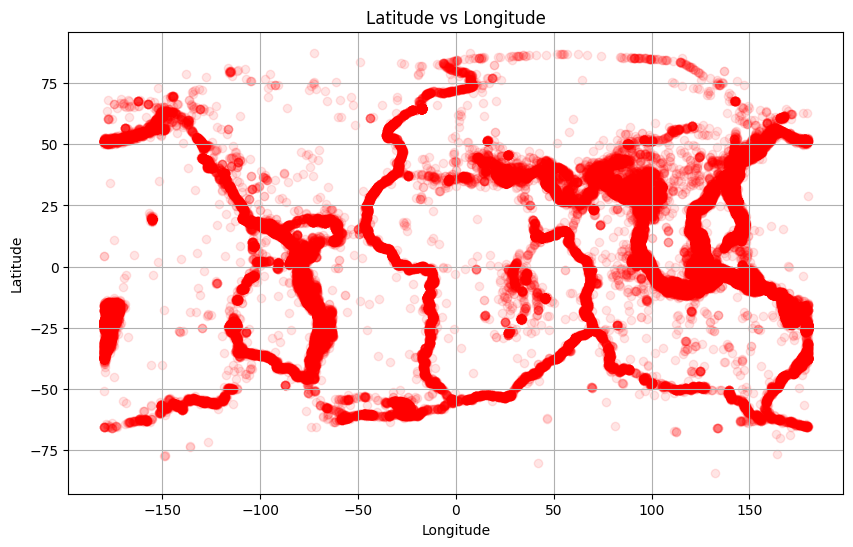

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(full_data['longitude'], full_data['latitude'], alpha=0.1, color='red')
plt.title("Location of Earthquakes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

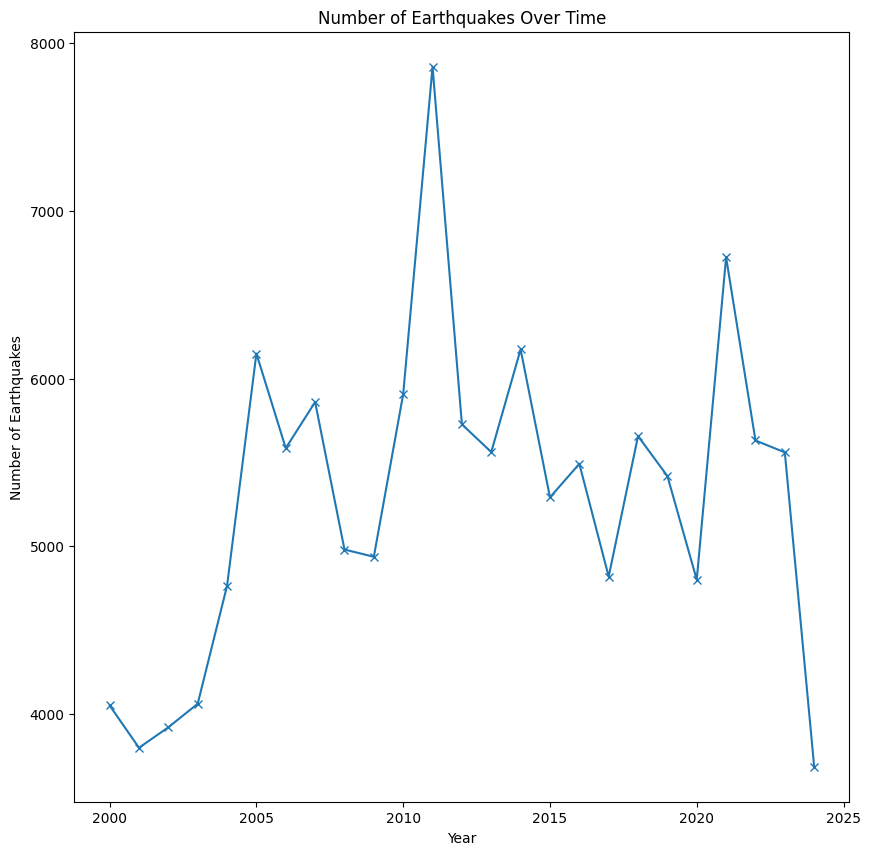

In [52]:

earthquakes_per_year = full_data.groupby(full_data['year']).size()
earthquakes_per_year.plot(figsize=(10, 10), marker='x')
plt.title("Number of Earthquakes Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.show()

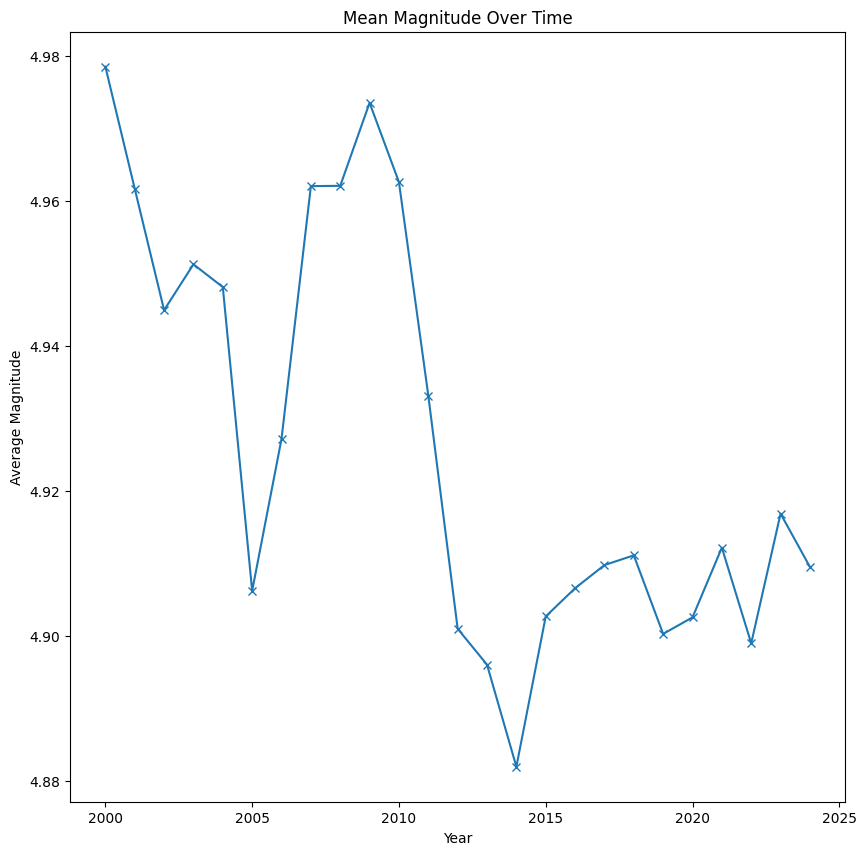

In [65]:

earthquakes_per_year = full_data.groupby('year')["magnitude"].mean()
earthquakes_per_year.plot(figsize=(10, 10), marker='x')
plt.title("Mean Magnitude Over Time")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.show()

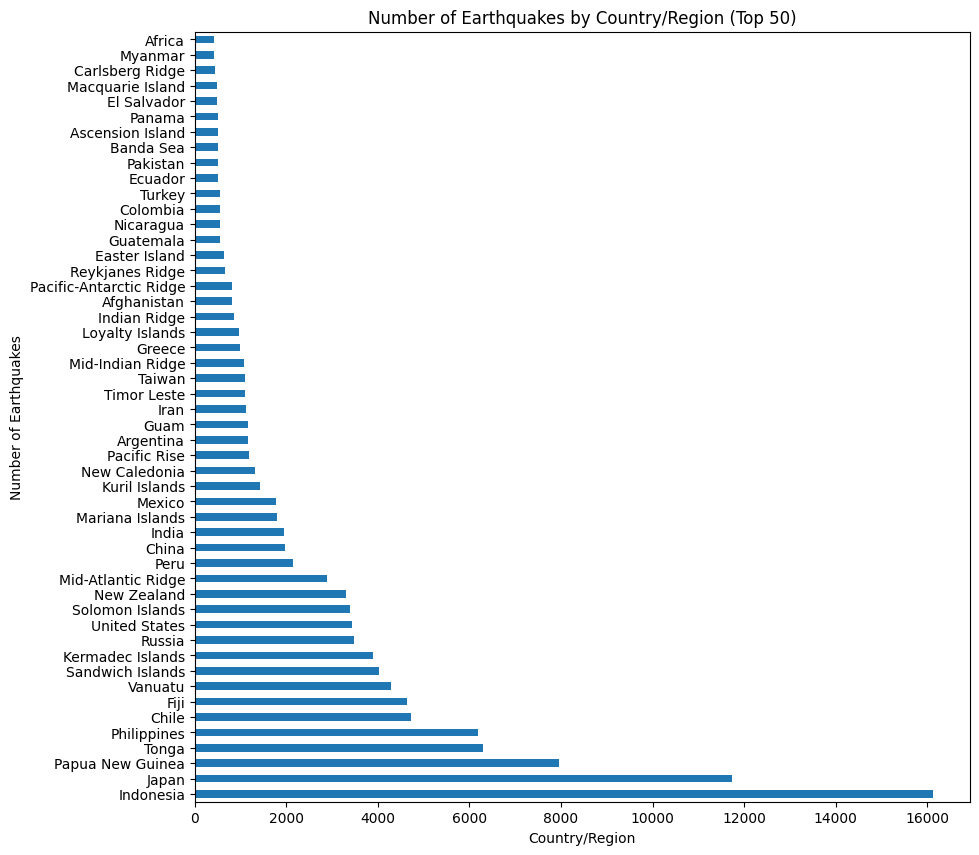

In [38]:
earthquake_count_by_country = full_data["location"].value_counts()
plt.figure(figsize=(10, 10))
earthquake_count_by_country[:50].plot(kind="barh")
plt.title("Number of Earthquakes by Country/Region (Top 50)")
plt.xlabel("Country/Region")
plt.ylabel("Number of Earthquakes")
plt.show()

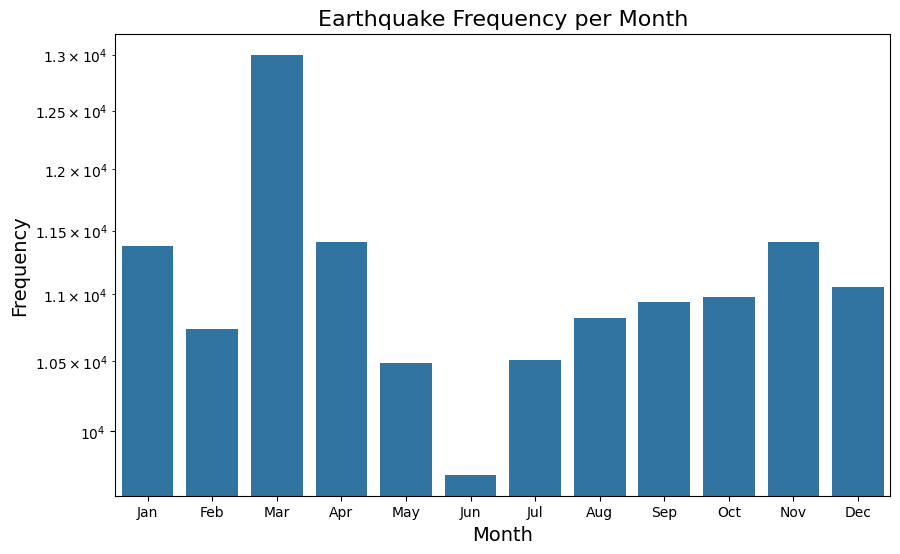

In [51]:
plt.figure(figsize=(10, 6))

sns.countplot(x='month', data=full_data)
plt.yscale("log")
plt.title('Earthquake Frequency per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

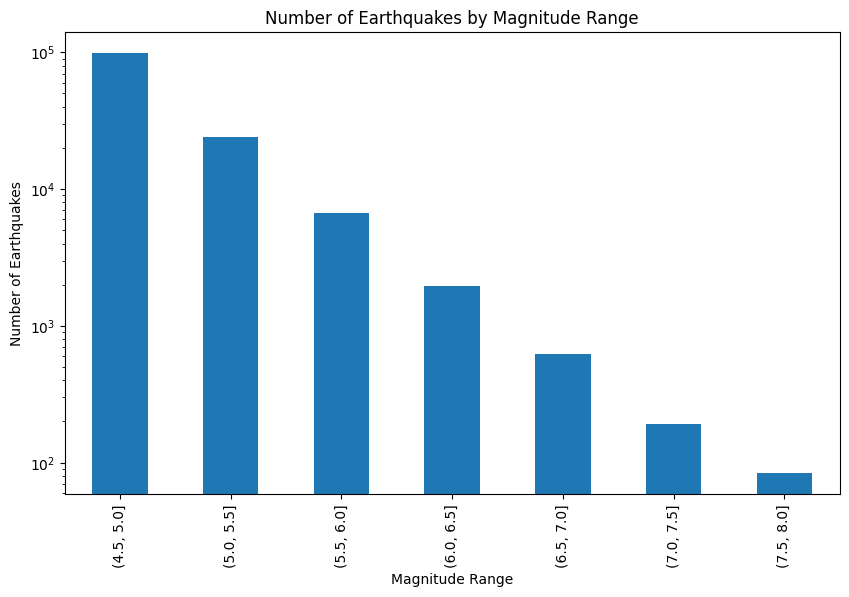

In [64]:
magnitude_bins = pd.cut(full_data["magnitude"], bins=[4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])
earthquake_counts_by_magnitude = magnitude_bins.value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.yscale("log")
earthquake_counts_by_magnitude.plot(kind='bar')
plt.title("Number of Earthquakes by Magnitude Range")
plt.xlabel("Magnitude Range")
plt.ylabel("Log Number of Earthquakes")
plt.show()


c:\Users\sanad\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


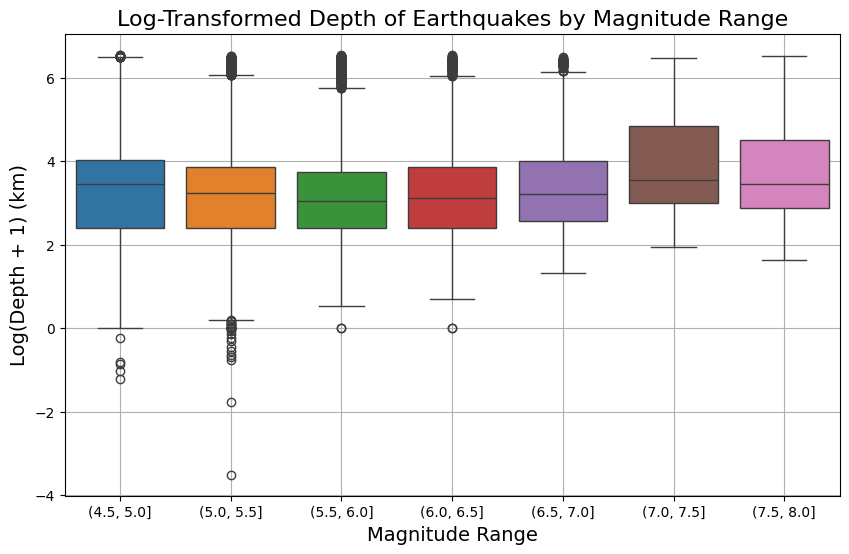

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=magnitude_bins, y=np.log1p(full_data['depth']), hue=magnitude_bins,legend=False)
plt.title('Log-Transformed Depth of Earthquakes by Magnitude Range', fontsize=16)
plt.xlabel('Magnitude Range', fontsize=14)
plt.ylabel('Log(Depth + 1) (km)', fontsize=14)
plt.grid(True)
plt.show()


**Conclusion**

In this assignment, we pulled global earthquake data from an API. The specific data we pulled was: 
    Location
    Latitude
    Longitude
    Depth
    Magnitude
    Time it Occurred
    The ID that was given to the Earthquake

The data was then cleaned and preprocessed to remove inconsistencies in location name and make it more usuable such as with the time it occured field. 

From the graphs/figures above, we can see that Earthquakes tend to occur more frequently near tectonic plate borders. The countries which experience the most earthquakes were Indonesia, Japan and Papua New Guinea which reside near tectonic plate borders. We also see that as the magnitude increases, the number of earthquakes also to decrease. As for the number of Earthquakes, we can see that from the year 2000 to 2001 there was a decrease but then began to increase until 2005. After that, there were period of increase and decrease, with the exception of 2011 which was a major increase and the highest amount of earthquakes.  Following that, we once again have periods of increase and decrease with a downwards trend. A similar effect is seen with mean magnitude over the 2 decades. Where is slightly decreases, but then sharply decreases in 2005 but increases sharply in 2006 where it hen peaks at in 2009. Then it begins a downwards trends where the lowest mean magnitude is recorded in 2014. htne it increases slowly. Plotting a histogram for the number of earthquakes aganist month, we see March has the most Earth quakes followed by April, January and November with June having the least amount of Earthquakes. The final 2 graphs tell us that lower magnitude earthquakes are more frequent than higher magnitude ones. However, higher magnitude ones occur ar greater depths as opposed to lower ones but lower magnitudes have a greater range of depth.


One noteworthy challenge encountered during the analysis was the preprocessing of regions. There where many inconsistencies in the data such as with the states in the United States, where state abbreviations needed to be converted to 'United States' for consistency. There were also points where location data was written three different was such as Japan, Japan Region and Japan Earthquake. Finally, because there was so much data (and even more I didn't include), it made pulling, processing and visualising data. As such, I had to pull data in two half-year blocks per year and apply logarimthic scaling to see the data better.

Some potential areas for further anaylsis:

    Dealing with Tsunamis: As these form when an earthquake occurs on the ocean. Thus being able to classify whether an earthquake lead to the formation of a tsunami would lead to interesting data

    Seasonal Shift Effects: Given a larger dataset with a longer historical record, we could investigate potential seasonal trends or patterns in earthquake occurrences to see seismic activity is affected by climate or seasonal changes.


 
